In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../processed/etf_returns.csv", parse_dates=["Date"])
df = df[["Date", "Ticker", "Daily_Return"]].dropna()
returns_wide = df.pivot(index="Date", columns="Ticker", values="Daily_Return").sort_index()

returns_wide.head()

Ticker,BND,IAU,MOAT,QUAL,QUS,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO,ZLB.TO
Date,,,,,,,,,,,,,,,
2014-01-03,0.000125,0.010943,-0.003151,-0.001961,NaN,0.001377,0.000612,-0.000164,-0.002211,0.003350,-0.003174,-0.000211,-0.002796,0.000661,-0.000988
2014-01-06,0.000873,0.000000,-0.004917,-0.003929,NaN,-0.003577,-0.003053,-0.002898,-0.004063,-0.008013,-0.001158,-0.002630,-0.004206,0.000661,-0.001484
2014-01-07,0.001248,-0.004996,0.008825,0.008069,NaN,0.005522,0.007349,0.006142,0.010015,0.005049,0.018255,0.006434,0.008446,0.002641,0.009906
2014-01-08,-0.003238,-0.005021,-0.003149,-0.000356,NaN,-0.003570,-0.004255,0.000218,0.001469,-0.001339,0.001993,0.000734,0.000931,0.000659,0.001471
2014-01-09,0.001874,0.002523,0.000351,-0.000534,NaN,0.001653,0.004274,0.000654,-0.000733,0.004695,0.005112,0.000838,0.000930,-0.000659,0.000979


In [5]:
needed = ["QUAL", "MOAT", "QUS", "SPY"]

available = set(returns_wide.columns)
missing = [t for t in needed if t not in available]

print("Available tickers (sample):", sorted(list(available))[:25])
print("Missing tickers:", missing)

Available tickers (sample): ['BND', 'IAU', 'MOAT', 'QUAL', 'QUS', 'SCHD', 'SPLV', 'SPY', 'VCN.TO', 'VDY.TO', 'VFV.TO', 'VTI', 'XIC.TO', 'ZAG.TO', 'ZLB.TO']
Missing tickers: []


In [6]:
factor_tickers =  ["QUAL", "MOAT", "QUS", "SPY"]

missing = [t for t in factor_tickers if t not in returns_wide.columns]
if missing:
    raise ValueError(f"Missing tickers in returns_wide: {missing}")

factor_data = returns_wide[factor_tickers].dropna()
factor_data.tail()

Ticker,QUAL,MOAT,QUS,SPY
Date,,,,
2026-01-27,0.002012,-0.002240,-0.001462,0.003984
2026-01-28,0.000637,-0.007763,-0.000732,-0.000101
2026-01-29,0.002301,-0.010086,0.001973,-0.001984
2026-01-30,-0.011331,-0.002571,-0.002531,-0.002983
2026-02-02,0.006472,0.003532,0.006260,0.004971


In [7]:
def annualized_return(r):
    r = r.dropna()
    return (1 + r).prod()**(252/len(r)) - 1

def sortino_ratio(r):
    r = r.dropna()
    ann_ret = annualized_return(r)
    downside = r[r < 0]
    downside_std = downside.std() * np.sqrt(252)

    # Avoid division by zero if downside_std is tiny
    if downside_std == 0 or np.isnan(downside_std):
        return np.nan
    return ann_ret / downside_std

def max_drawdown(r):
    r = r.dropna()
    cum = (1 + r).cumprod()
    dd = (cum / cum.cummax()) - 1
    return dd.min()

rows = []
for t in factor_tickers:
    r = factor_data[t]
    rows.append({
        "ETF": t,
        "Annualized Return": annualized_return(r),
        "Sortino": sortino_ratio(r),
        "Max Drawdown": max_drawdown(r),
    })

factor_df = pd.DataFrame(rows).set_index("ETF").sort_values("Sortino", ascending=False)
factor_df

,Annualized Return,Sortino,Max Drawdown
ETF,,,
SPY,0.136340,0.924749,-0.337173
MOAT,0.133145,0.917850,-0.333098
QUAL,0.129974,0.899004,-0.340567
QUS,0.126384,0.844837,-0.337766


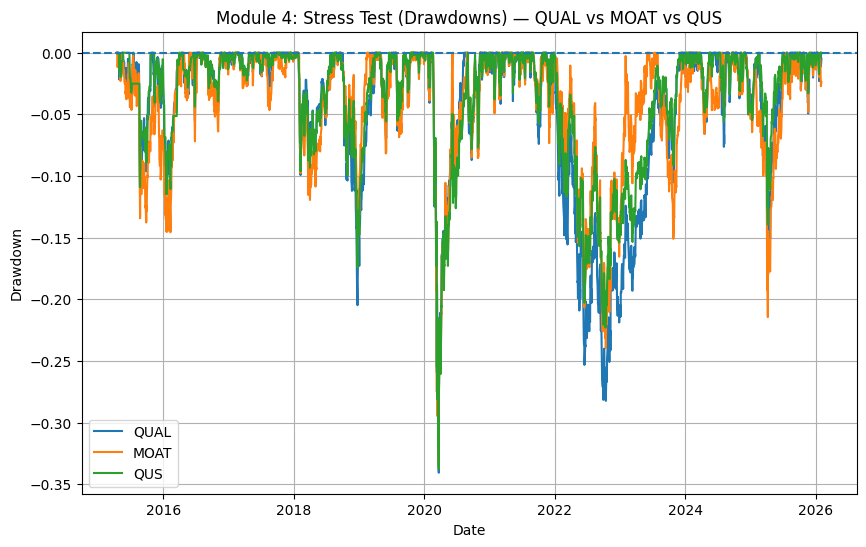

In [8]:
plt.figure(figsize=(10, 6))

for t in ["QUAL", "MOAT", "QUS"]:
    r = factor_data[t]
    cum = (1 + r).cumprod()
    dd = (cum / cum.cummax()) - 1
    plt.plot(dd, label=t)

plt.axhline(0, linestyle="--")
plt.title("Module 4: Stress Test (Drawdowns) — QUAL vs MOAT vs QUS")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


Running 10000 simulations based on 2658 days of history...

--- FINAL EXECUTIVE METRICS ---
Portfolio: 40% SCHD | 25% ZLB | 20% QUS | 15% IAU
Probability of Positive Return (5 Year): 96.8%
Worst Case Scenario (CVaR 95%): -5.1%
Median Expected Return: 68.6%


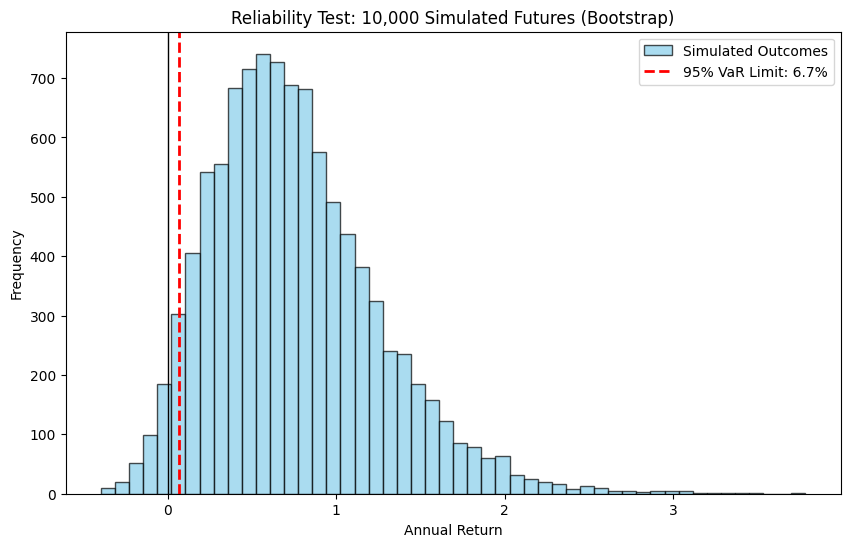

In [12]:
# final portfolio
weights = {
"SCHD": 0.40,   # US Core (Dividend + Defense)
"ZLB.TO": 0.25, # CAD Core (Low Volatility)
"QUS": 0.20,    # Quality Satellite (Strategic Factors)
"IAU": 0.15     # Hedge Gold
}

final_tickers = list(weights.keys())
port_data = returns_wide[final_tickers].dropna()

port_data['Defensive_Growth'] = (
    (port_data['SCHD'] * weights['SCHD']) +
    (port_data['ZLB.TO'] * weights['ZLB.TO']) +
    (port_data['QUS'] * weights['QUS']) +
    (port_data['IAU'] * weights['IAU'])
)

# 3. Run Monte Carlo Bootstrap (10,000 Simulations)
# We resample the last ~10 years of daily history
simulations = 10000
trading_days = 1260 # 5 Year
simulated_annual_returns = []

np.random.seed(42) # For reproducible results

print(f"Running {simulations} simulations based on {len(port_data)} days of history...")

for i in range(simulations):
    # Randomly pick 252 daily returns from our history (with replacement)
    daily_samples = np.random.choice(port_data['Defensive_Growth'], size=trading_days, replace=True)
    # Calculate cumulative return for that simulated year
    annual_return = np.prod(1 + daily_samples) - 1
    simulated_annual_returns.append(annual_return)

# 4. Calculate Key Metrics
sim_results = np.array(simulated_annual_returns)

# CVaR (Conditional Value at Risk): Average of the worst 5% cases
worst_5_percent = np.percentile(sim_results, 5)
cvar_95 = sim_results[sim_results <= worst_5_percent].mean()

# Probability of Profit
prob_positive = (sim_results > 0).mean()

print("\n--- FINAL EXECUTIVE METRICS ---")
print(f"Portfolio: 40% SCHD | 25% ZLB | 20% QUS | 15% IAU")
print(f"Probability of Positive Return (5 Year): {prob_positive:.1%}")
print(f"Worst Case Scenario (CVaR 95%): {cvar_95:.1%}")
print(f"Median Expected Return: {np.median(sim_results):.1%}")

# 5. Visual Proof for Tosin
plt.figure(figsize=(10,6))
plt.hist(sim_results, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Simulated Outcomes')
plt.axvline(worst_5_percent, color='red', linestyle='--', linewidth=2, label=f'95% VaR Limit: {worst_5_percent:.1%}')
plt.axvline(0, color='black', linewidth=1)
plt.title('Reliability Test: 10,000 Simulated Futures (Bootstrap)')
plt.xlabel('Annual Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Running 10000 simulations of 5 years...

--- EXECUTIVE WEALTH SUMMARY (5 YEARS) ---
Starting Capital: $10,000
Win Rate (Probability of Profit): 97.1%
----------------------------------------
90th Percentile (Lucky):      $24,045 (+140%)
50th Percentile (Expected):   $16,844 (+68%)
10th Percentile (Unlucky):    $11,737 (+17%)
5th Percentile (Worst Case):  $10,643 (+6%)


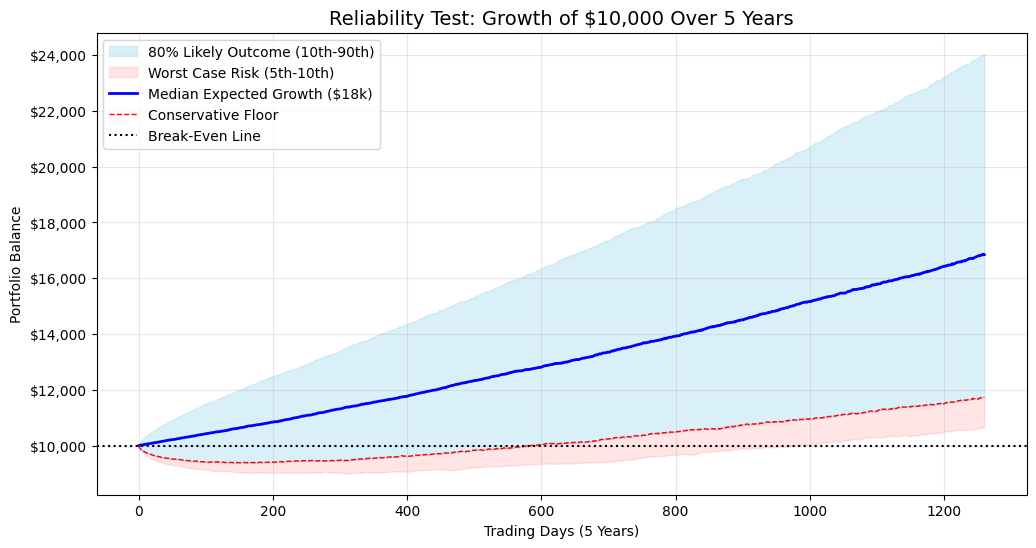

In [14]:
import matplotlib.ticker as mtick

# 1. Configuration
initial_capital = 10000
years = 5
trading_days_per_year = 252
total_days = years * trading_days_per_year
simulations = 10000

# 2. Define the Portfolio Weights
weights = {
    'SCHD': 0.40,
    'ZLB.TO': 0.25,
    'QUS': 0.20,
    'IAU': 0.15
}

# 3. Create the Synthetic Portfolio History
# (Assuming 'returns_wide' is your dataframe of daily returns)
final_tickers = list(weights.keys())
port_data = returns_wide[final_tickers].dropna()

# Calculate Daily Weighted Return of the strategy
daily_returns = (port_data * pd.Series(weights)).sum(axis=1)

# 4. Run Monte Carlo Bootstrap (Path Simulation)
# We simulate 10,000 different "5-Year Paths"
np.random.seed(42)  # For consistent results

print(f"Running {simulations} simulations of {years} years...")

# Create a matrix: Rows = Days, Columns = Simulation Run
# We randomly sample daily returns to fill this matrix
random_returns = np.random.choice(daily_returns, size=(total_days, simulations), replace=True)

# Convert returns to "Growth of $10,000"
# Formula: $10,000 * (1 + r1) * (1 + r2) ...
cumulative_growth = np.cumprod(1 + random_returns, axis=0) * initial_capital

# Add the starting row ($10,000 at Day 0)
start_row = np.full((1, simulations), initial_capital)
wealth_paths = np.vstack([start_row, cumulative_growth])

# 5. Calculate Key Percentiles (The "Cone")
# We calculate the 10th, 50th, and 90th percentile value for EVERY day
p90 = np.percentile(wealth_paths, 90, axis=1) # Best Case (Lucky)
p50 = np.percentile(wealth_paths, 50, axis=1) # Median (Expected)
p10 = np.percentile(wealth_paths, 10, axis=1) # Worst Case (Unlucky)
p05 = np.percentile(wealth_paths, 5, axis=1)  # Safety Floor (CVaR zone)

# 6. Generate the "Executive Summary" Table
final_values = wealth_paths[-1, :] # The ending balances
win_rate = (final_values > initial_capital).mean()

print("\n--- EXECUTIVE WEALTH SUMMARY (5 YEARS) ---")
print(f"Starting Capital: ${initial_capital:,.0f}")
print(f"Win Rate (Probability of Profit): {win_rate:.1%}")
print("-" * 40)
print(f"90th Percentile (Lucky):      ${np.percentile(final_values, 90):,.0f} (+{(np.percentile(final_values, 90)/initial_capital)-1:.0%})")
print(f"50th Percentile (Expected):   ${np.median(final_values):,.0f} (+{(np.median(final_values)/initial_capital)-1:.0%})")
print(f"10th Percentile (Unlucky):    ${np.percentile(final_values, 10):,.0f} (+{(np.percentile(final_values, 10)/initial_capital)-1:.0%})")
print(f"5th Percentile (Worst Case):  ${np.percentile(final_values, 5):,.0f} (+{(np.percentile(final_values, 5)/initial_capital)-1:.0%})")

# 7. Visual: The "Cone of Uncertainty"
plt.figure(figsize=(12, 6))
days = range(len(p50))

# Plot the Cone
plt.fill_between(days, p10, p90, color='skyblue', alpha=0.3, label='80% Likely Outcome (10th-90th)')
plt.fill_between(days, p05, p10, color='red', alpha=0.1, label='Worst Case Risk (5th-10th)')

# Plot the Lines
plt.plot(days, p50, color='blue', linewidth=2, label='Median Expected Growth ($18k)')
plt.plot(days, p10, color='red', linestyle='--', linewidth=1, label='Conservative Floor')

# Formatting
plt.title(f'Reliability Test: Growth of ${initial_capital:,} Over 5 Years', fontsize=14)
plt.xlabel('Trading Days (5 Years)')
plt.ylabel('Portfolio Balance')
plt.axhline(initial_capital, color='black', linestyle=':', label='Break-Even Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Format Y-axis as Dollars
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

plt.show()